In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
X = np.load('speaker-4m-e1_best_epoch_emb10.npy') ## (56731, 512)
X_labels = np.squeeze(np.load('speaker-4m-e1_best_epoch_emb_locations.npy')) ## (56731, 2)
X_type = np.load('speaker-4m-e1_best_epoch_emb_type.npy').astype(int) ## (56731, )
# print(X_type) # [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,13., 14., 15., 16., 17.] 18 in total
# [b'dfm-loud' b'dfm-medium' b'dfm-soft' b'sc-loud' b'sc-medium' b'sc-soft'
#  b'stack-loud' b'stack-medium' b'stack-soft' b'upfm-loud' b'upfm-medium'
#  b'upfm-soft' b'warble-loud' b'warble-medium' b'warble-soft' b'white-loud'
#  b'white-medium' b'white-soft']
from PR_Dim import PR_Dim
pr, pr_corrected, d_expvar, cumulative_variance = PR_Dim(X)

emb shape(56731, 512)


In [2]:
print(f"All Manifold PR: {pr:.3f} Corrected-PR: {pr_corrected:.3f} Dim 90% Var: {d_expvar:.0f}")
cumulative_variance[:19]

All Manifold PR: 14.273 Corrected-PR: 14.277 Dim 90% Var: 56


array([0.16515259, 0.29940419, 0.40673713, 0.47350871, 0.51946095,
       0.55992081, 0.59449776, 0.62353598, 0.64852941, 0.66923974,
       0.6878115 , 0.70289429, 0.71705994, 0.72983034, 0.74072052,
       0.75038879, 0.75968045, 0.76812608, 0.77615603])

In [3]:
# List of the 6 main types in order
types = ['dfm', 'sc', 'stack', 'upfm', 'warble', 'white']
for i, name in enumerate(types):
    target_values = [3*i, 3*i+1, 3*i+2] # dfm (i=0) -> 0, 1, 2    sc  (i=1) -> 3, 4, 5
    mask = np.isin(X_type, target_values)
    X_subset = X[mask]
    pr, pr_corrected, d_expvar, cumulative_variance = PR_Dim(X_subset)
    print(f"Type: {name} PR: {pr:.3f} PR-C: {pr_corrected:.3f} D90%: {d_expvar:.0f}")

emb shape(9434, 512)
Type: dfm PR: 11.203 PR-C: 11.217 D90%: 52
emb shape(9490, 512)
Type: sc PR: 9.212 PR-C: 9.221 D90%: 37
emb shape(9436, 512)
Type: stack PR: 9.836 PR-C: 9.846 D90%: 36
emb shape(9417, 512)
Type: upfm PR: 10.846 PR-C: 10.859 D90%: 44
emb shape(9460, 512)
Type: warble PR: 6.949 PR-C: 6.954 D90%: 24
emb shape(9494, 512)
Type: white PR: 8.296 PR-C: 8.303 D90%: 22


In [13]:
print(np.mean([11.203, 9.212, 9.836, 10.846, 6.949, 8.296]))
print(np.mean([11.217, 9.221, 9.846, 10.859, 6.954, 8.303]))
print(np.std([11.217, 9.221, 9.846, 10.859, 6.954, 8.303]))
print(np.mean([52, 37, 36, 44, 24, 22]))
print(np.std([52, 37, 36, 44, 24, 22]))

9.390333333333333
9.4
1.4632983291181605
35.833333333333336
10.49470766095411


emb shape(9434, 512)
emb shape(9490, 512)
emb shape(9436, 512)
emb shape(9417, 512)
emb shape(9460, 512)
emb shape(9494, 512)
Elbow detected at Component: 4 (Index 3)


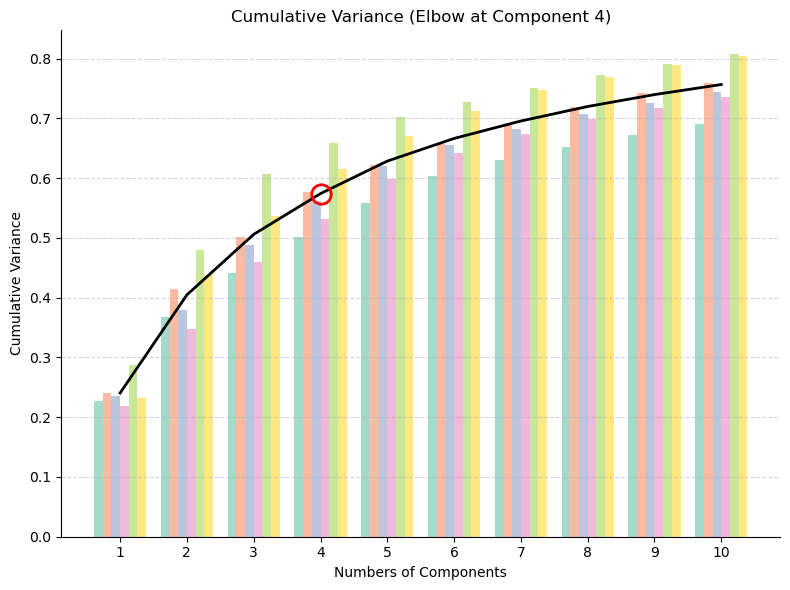

Mean Cumulative Variance (First 10 components):
[0.24059905 0.40485464 0.50609181 0.57431805 0.62871296 0.66660874
 0.69579627 0.72009627 0.7400082  0.7568521 ]


In [5]:
# --- 1. Setup & Data Calculation ---
palette = sns.color_palette('Set2', 6)
types = ['dfm', 'sc', 'stack', 'upfm', 'warble', 'white']
n_components = 10
bar_width = 0.13
indices = np.arange(n_components)
all_variances = []

# (Your existing loop to gather data)
for i, name in enumerate(types):
    target_values = [3*i, 3*i+1, 3*i+2]
    mask = np.isin(X_type, target_values)
    X_subset = X[mask]
    
    # Run Dim Red and get individual explained variance
    pr, pr_corrected, d_expvar, cumulative_variance = PR_Dim(X_subset)
    
    # Store first 10
    all_variances.append(cumulative_variance[:n_components])

# Calculate Mean Curve
mean_values = np.mean(all_variances, axis=0)

# --- 2. Auto-Detect Elbow (Geometric Method) ---
def get_elbow_index(values):
    """Finds the point of max distance from the line connecting first and last points."""
    n_points = len(values)
    all_coords = np.vstack((range(n_points), values)).T
    
    # Vector from start to end
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    # Vector from start to every point
    vec_from_first = all_coords - all_coords[0]
    
    # Project and subtract to get perpendicular distance
    scalar_product = np.sum(vec_from_first * line_vec_norm, axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    # Max distance is the elbow
    return np.argmax(dist_to_line)

elbow_idx = get_elbow_index(mean_values)
print(f"Elbow detected at Component: {elbow_idx + 1} (Index {elbow_idx})")

# --- 3. Plotting ---
# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(8, 6))    

# Plot Bars
for i, name in enumerate(types):
    plt.bar(indices + (i * bar_width), all_variances[i], 
            width=bar_width, color=palette[i], label=name, alpha=0.6)

# Plot Mean Line
center_offset = (len(types) * bar_width) / 2 - (bar_width / 2)
plt.plot(indices + center_offset, mean_values, 
         color='black', linewidth=2, label='Mean Variance')

# Highlight Elbow Point
plt.plot(elbow_idx + center_offset, mean_values[elbow_idx], 
         marker='o', markersize=14, 
         markeredgecolor='red', markerfacecolor='none', markeredgewidth=2,
         label=f'Elbow at Comp {elbow_idx + 1}')

# Formatting
plt.title(f'Cumulative Variance (Elbow at Component {elbow_idx+1})')
plt.xlabel('Numbers of Components')
plt.ylabel('Cumulative Variance')
plt.xticks(indices + center_offset, np.arange(1, n_components + 1)) # Labels 1-10
# plt.legend(loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
sns.despine()
plt.show()
# fig.savefig("2m24_sound_types_L10_Explained Variance.pdf", format='pdf', bbox_inches='tight')
print("Mean Cumulative Variance (First 10 components):")
print(mean_values)

In [3]:
n_neighbors = 500
min_dist = 1
state_id = 0
umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, 
                       n_components=2, n_jobs = 8, random_state=state_id) #### Use no seed for parallelism ####
umap_results = umap_model.fit_transform(X) ## (56731, 2)

/home/marmoset/miniconda3/envs/vcl/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/marmoset/miniconda3/envs/vcl/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [4]:
model_raw = LinearRegression()
model_raw.fit(X, X_labels)
pred_x_raw = model_raw.predict(X)
r2_raw = np.round(r2_score(X_labels, pred_x_raw),2)

model_2d = LinearRegression()
model_2d.fit(umap_results, X_labels)
pred_x_2d = model_2d.predict(umap_results)
r2_2d = np.round(r2_score(X_labels, pred_x_2d),2)
print('r2: raw='+str(r2_raw)+' 2d='+str(r2_2d))

r2: raw=0.88 2d=0.16


/tmp/ipykernel_26531/553823959.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=umap_df, x='umap1', y='umap2',


<Axes: xlabel='umap1', ylabel='umap2'>

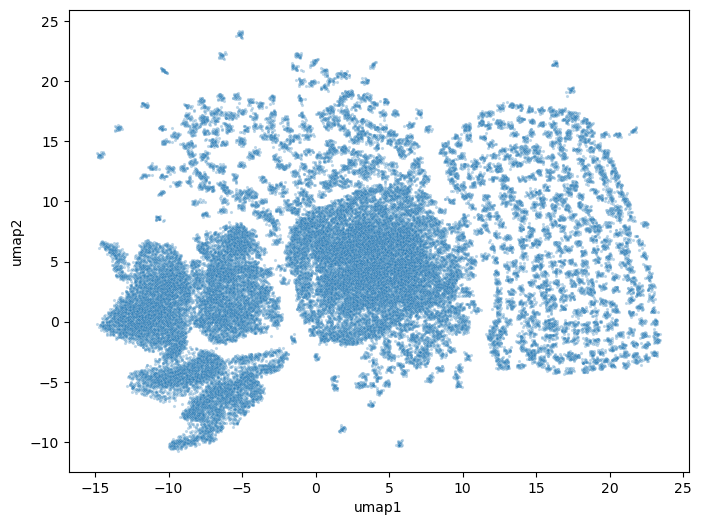

In [5]:
umap_df = pd.DataFrame(umap_results, columns=['umap1', 'umap2'])
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='umap1', y='umap2', 
                palette='tab20', alpha=0.3, s=5)

In [6]:
# 0) 18 full labels in the same order as their numeric codes  
stim_labels = np.array([
    b'dfm-loud', b'dfm-medium', b'dfm-soft',
    b'sc-loud',  b'sc-medium',  b'sc-soft',
    b'stack-loud', b'stack-medium', b'stack-soft',
    b'upfm-loud',  b'upfm-medium',  b'upfm-soft',
    b'warble-loud', b'warble-medium', b'warble-soft',
    b'white-loud',  b'white-medium',  b'white-soft'
])

# 1) collapse 18 → 6 by dropping the “‑loud/‑medium/‑soft” suffix
# base_types = np.char.split(stim_labels.astype(str), sep='-').str[0]
base_types = np.array([s.split('-')[0] for s in stim_labels.astype(str)])


# 2) map each sample’s numeric code in X_type to its base type string
stim_base = base_types[X_type]          # shape (6158,)

# 3) choose 6 distinct colours and build a lookup table
palette = sns.color_palette('Set2', 6)  # or 'tab10', 'Dark2', …
type_to_color = dict(zip(np.unique(base_types), palette))

# 4) colour array for the scatter
colors = [type_to_color[t] for t in stim_base]

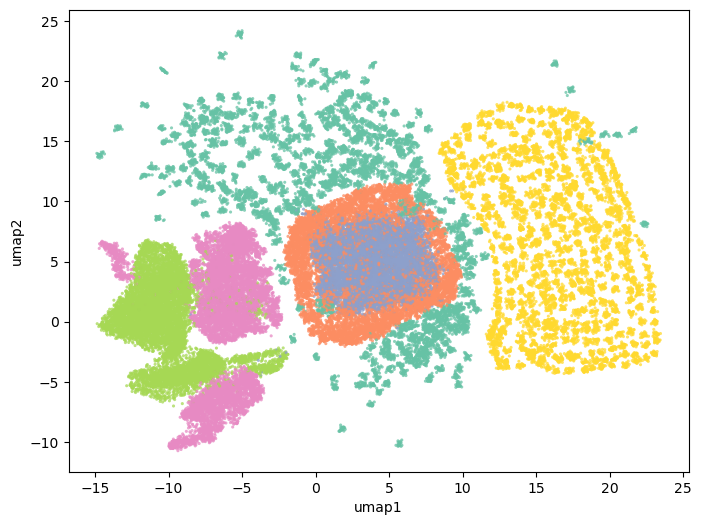

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))    
umap_df['stim_type'] = stim_base            # 6 categorical labels
scatter = sns.scatterplot(
    data=umap_df, x='umap1', y='umap2',
    hue='stim_type', palette=type_to_color,   # categorical palette
    s=5, alpha=0.75, linewidth=0, ax=ax, legend=False
)
# ax.legend(title='Stimulus type', loc='upper left', markerscale=3)
fig.savefig("2m24_sound_types_L10.pdf", format='pdf', bbox_inches='tight')

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

# REQUIRED: umap_results: array of shape (N, 2)
# OPTIONAL: y_true: array of shape (N,)  NMI/ARI will be computed against it

def evaluate_kmeans(umap_results, n_clusters, y_true=None, sample_size=20000, random_state=0):
    umap_results = np.asarray(umap_results)

    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    y_pred = km.fit_predict(umap_results)

    # Silhouette on embeddings with predicted labels
    if len(umap_results) > sample_size:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(len(umap_results), size=sample_size, replace=False)
        sil = silhouette_score(umap_results[idx], y_pred[idx], metric="euclidean")
    else:
        sil = silhouette_score(umap_results, y_pred, metric="euclidean")

    out = {"SILH": sil, "y_pred": y_pred}

    # If ground truth provided, report NMI & ARI too
    if y_true is not None:
        y_true = np.asarray(y_true)
        out["NMI"] = normalized_mutual_info_score(y_true, y_pred)
        out["ARI"] = adjusted_rand_score(y_true, y_pred)

    print(f"SILH: {out['SILH']:.4f}")
    if "NMI" in out:
        print(f"NMI:  {out['NMI']:.4f}")
        print(f"ARI:  {out['ARI']:.4f}")
    return out

# Example:
out = evaluate_kmeans(umap_results, n_clusters=len(np.unique(stim_base)), y_true=stim_base)


SILH: 0.4172
NMI:  0.6233
ARI:  0.4380
